In [1]:
from collections import defaultdict
from dataclasses import dataclass
from sortedcontainers import SortedList
from typing import Optional
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [2]:
CHROMHMM_DIR = "chromHMM_bed"
CHROMHMM_FILES_METADATA = "chromhmm_file_metadata.tsv"
EQTLS_PATH = "../merged_eqtl_results.tsv"

In [3]:
eqtl_df = pd.read_csv(EQTLS_PATH, sep="\t", header=0, index_col=0)
eqtl_df = eqtl_df[eqtl_df["finemapped"]].copy()
eqtl_df.head()

,chromosome,start,end,variant,allele1,allele2,minor_allele,tissue,gene,maf,...,CAGE_SAD_5,DNase_SAD_5,n_pos_CAGE_SAD,n_neg_CAGE_SAD,n_agree_CAGE_SAD,n_correct_CAGE_SAD,n_pos_DNase_SAD,n_neg_DNase_SAD,n_agree_DNase_SAD,n_correct_DNase_SAD
114591,chr10,101031041,101031042,chr10_101031042_C_A_b38,C,A,A,Pancreas,ENSG00000186862.17,0.324590,...,-1.336000,0.175800,0,5,5,5,4,1,4,1
114592,chr10,101032472,101032473,chr10_101032473_G_T_b38,G,T,T,Pancreas,ENSG00000107819.13,0.060656,...,-0.886700,0.214800,0,5,5,0,4,1,4,4
114593,chr10,101037501,101037502,chr10_101037502_C_T_b38,C,T,T,Pancreas,ENSG00000107819.13,0.229508,...,-0.029300,0.001953,0,5,5,0,3,2,3,3
115031,chr10,102856742,102856743,chr10_102856743_T_C_b38,T,C,C,Pancreas,ENSG00000166275.15,0.232787,...,0.001709,0.007324,3,2,3,2,5,0,5,0
115039,chr10,102876897,102876898,chr10_102876898_G_C_b38,G,C,C,Pancreas,ENSG00000214435.7,0.142623,...,0.014770,0.072270,5,0,5,5,5,0,5,5


In [4]:
chromhmm_files_df = pd.read_csv(CHROMHMM_FILES_METADATA, sep="\t", header=0, index_col=0)
tissue_to_chromhmm_file_id = chromhmm_files_df["chromHMM_encode_file_id"].to_dict()

In [17]:
@dataclass(frozen=True)
class HalfOpenInterval:
    chrom: str
    start: int # inclusive 
    end: int # exclusive
    annotation: Optional[str] = None
    
    def overlaps(self, other):
        if self.chrom != other.chrom:
            return False
        return (self.start < other.end) and (other.start < self.end)
    
    def __len__(self):
        return self.end - self.start
    
    def __lt__(self, other):
        if self.chrom != other.chrom:
            return self.chrom < other.chrom
        else:
            return self.start < other.start

In [18]:
def load_chromhmm_annotations(tissue):
    chromhmm_fid = tissue_to_chromhmm_file_id[tissue]
    chromhmm_fpath = os.path.join(CHROMHMM_DIR, f"{chromhmm_fid}.bed.gz")
    df = pd.read_csv(
        chromhmm_fpath,
        sep="\t",
        header=None,
        usecols=list(range(4)),
        names=["chrom", "start", "end", "annotation"]
    )
    
    intervals_by_chrom = defaultdict(list)
    for (chrom, start, end, annot) in zip(df["chrom"], df["start"], df["end"], df["annotation"]):
        interval = HalfOpenInterval(chrom, start, end, annot)
        intervals_by_chrom[interval.chrom].append(interval)
    
    return {
        chrom: SortedList(intervals)
        for chrom, intervals in intervals_by_chrom.items()
    }

# Plot consistency per chromHMM annotation

In [19]:
def find_overlapping_interval(sorted_intervals, new_interval):
    insert_pos = sorted_intervals.bisect_left(new_interval)
    if insert_pos > 0 and sorted_intervals[insert_pos - 1].overlaps(new_interval):
        return sorted_intervals[insert_pos - 1]
    if insert_pos < len(sorted_intervals) and sorted_intervals[insert_pos].overlaps(new_interval):
        return sorted_intervals[insert_pos]
    return None


def add_consistency_counts_by_annotation(
    tissue: str, tissue_df: pd.DataFrame, counts: dict, assay: str
):
    assert assay in ["CAGE", "DNase"]
    
    consistency_map = {5: "consistently correct", 0: "consistently incorrect"}
    intervals_by_chrom = load_chromhmm_annotations(tissue)
    
    for (variant, n_correct) in zip(tissue_df["variant"], tissue_df[f"n_correct_{assay}_SAD"]):
        consistency = consistency_map.get(n_correct, "inconsistent")
        chrom, pos, *_ = variant.split("_")
        vi = HalfOpenInterval(chrom, int(pos), int(pos) + 1, None)
        overlapping_interval = find_overlapping_interval(intervals_by_chrom[vi.chrom], vi)
        annot = overlapping_interval.annotation if overlapping_interval else "Unannotated"
        counts[annot][consistency] += 1
    
    intervals_by_chrom = load_chromhmm_annotations(tissue)

            
def compute_bootstrapped_proportions(
    consistently_correct: int, 
    inconsistent: int, 
    consistently_incorrect: int,
    bootstraps = 1_000
):
    values = np.array(
        ["consistently correct"] * consistently_correct 
        + ["inconsistent"] * inconsistent 
        + ["consistently incorrect"] * consistently_incorrect
    )
    
    proportions = defaultdict(list) 
    for _ in range(bootstraps):
        bs_values = np.random.choice(values, size=values.size, replace=True)
        for category in ["consistently correct", "inconsistent", "consistently incorrect"]:
            proportions[category].append(np.mean(bs_values == category))
    return proportions

            
def plot_consistency_proportions(counts: dict[dict[str, int]], assay):
    annots = sorted(counts.keys(), key=lambda x: sum(counts[x].values()), reverse=True)
    
    proportions = defaultdict(list)
    for annot in annots:
        annot_proportions = compute_bootstrapped_proportions(
            counts[annot]["consistently correct"], 
            counts[annot]["inconsistent"], 
            counts[annot]["consistently incorrect"]
        )
        
        for k, v in annot_proportions.items():
            n_bootstraps = len(v)
            proportions[k] += v
        proportions["annotation"] += [annot] * n_bootstraps    
    
    proportions_df = pd.DataFrame.from_dict(proportions)
    proportions_df = proportions_df.melt(id_vars="annotation", var_name="consistency", value_name="proportion")
    
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.barplot(data=proportions_df, x="annotation", y="proportion", hue="consistency", errorbar=("sd", 1), ax=ax)
    
    ax.set_xlabel("chromHMM annotation", fontsize=12)
    ax.set_ylabel("Proportion of variants within annotation", fontsize=12)
    ax.set_title("chromHMM annotation of finemapped variants", fontsize=14)
    ax.set_xticklabels(
        [f"{a}\n(N={sum(counts[a].values())})" for a in annots],
        fontsize=12, 
        rotation=60, 
        ha="center"
    )
    ax.legend(
        title=f"consistency in sign prediction\nusing {assay} tracks", 
        bbox_to_anchor=(1.02, 1.0), 
        frameon=False
    )
    plt.show()

100%|██████████| 13/13 [00:25<00:00,  1.95s/it]


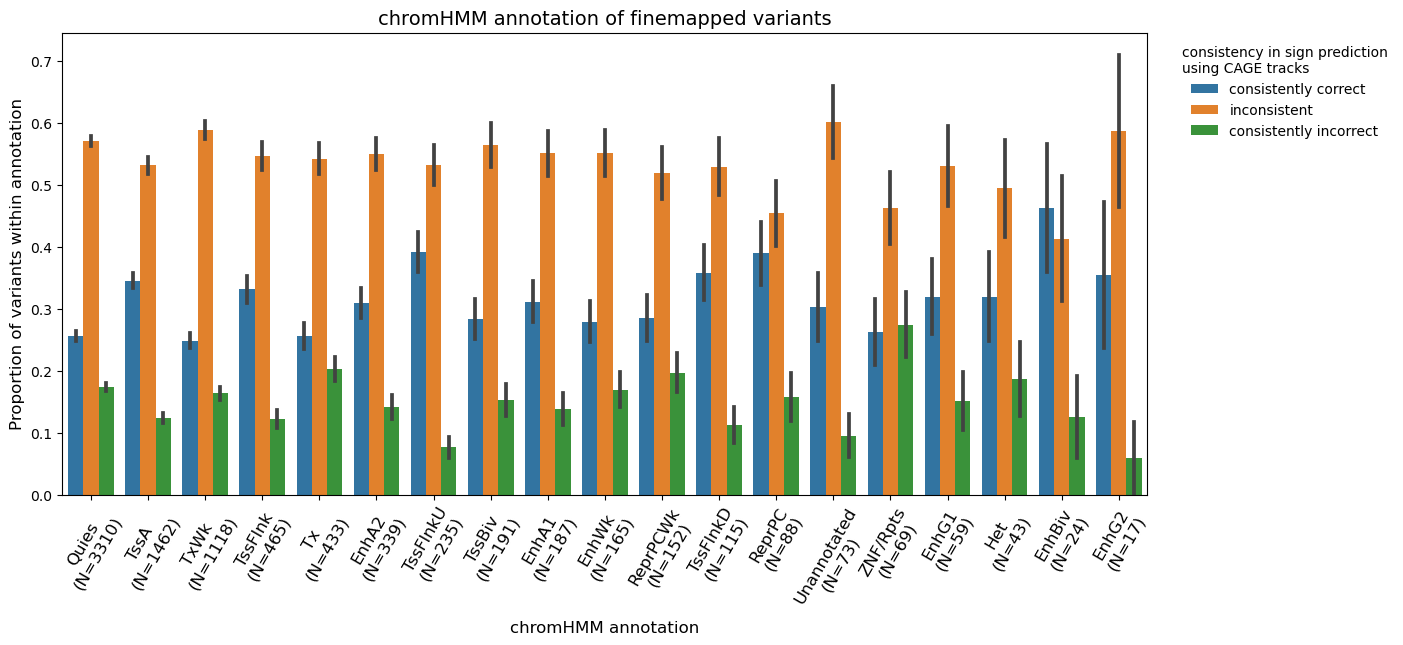

In [14]:
consistency_counts = defaultdict(lambda: defaultdict(int))
for tissue, tissue_df in tqdm(eqtl_df.groupby("tissue")):
    add_consistency_counts_by_annotation(tissue, tissue_df, consistency_counts, assay="CAGE")
plot_consistency_proportions(consistency_counts, "CAGE")

100%|██████████| 13/13 [00:25<00:00,  1.94s/it]


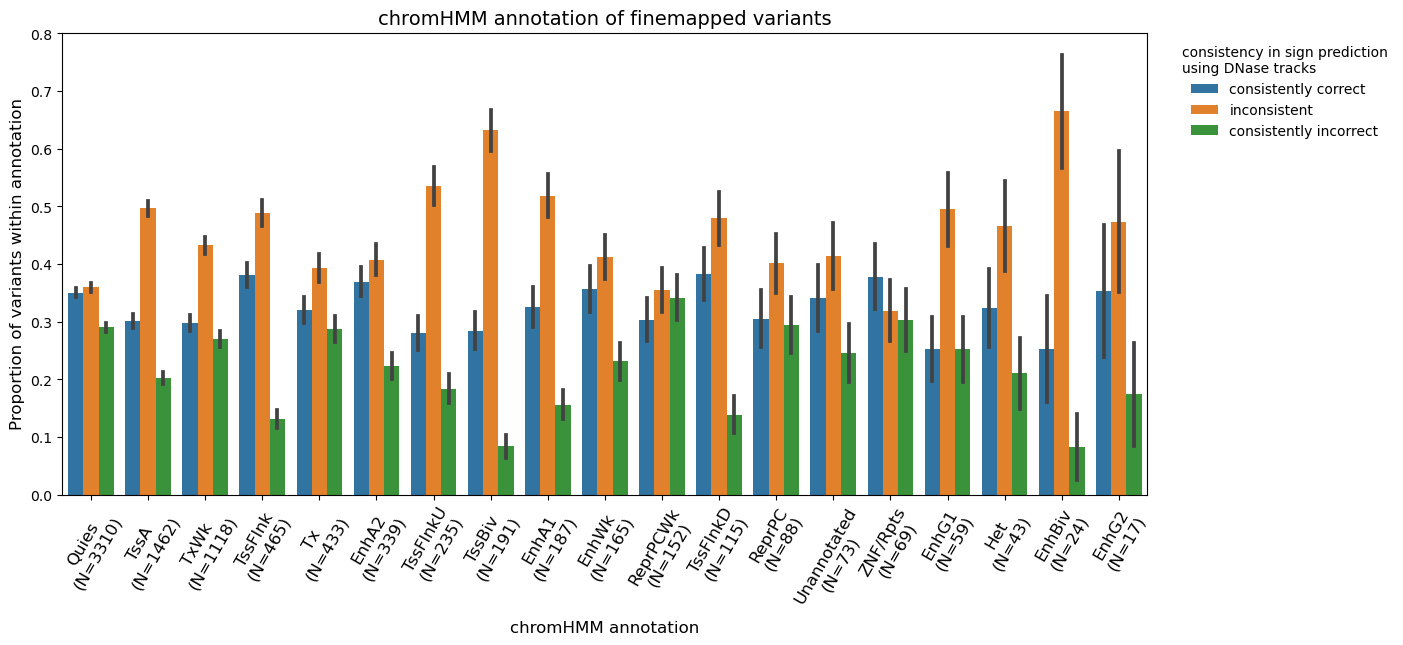

In [16]:
consistency_counts = defaultdict(lambda: defaultdict(int))
for tissue, tissue_df in tqdm(eqtl_df.groupby("tissue")):
    add_consistency_counts_by_annotation(tissue, tissue_df, consistency_counts, assay="DNase")
plot_consistency_proportions(consistency_counts, "DNase")

# Plot eQTL enrichment per chromHMM annotation

In [67]:
def compute_annotation_enrichments(tissue, tissue_df):
    intervals_by_chrom = load_chromhmm_annotations(tissue)
    
    # Compute span per annotation
    spans = defaultdict(int)
    for chrom, intervals in intervals_by_chrom.items():
        for i in intervals:
            spans[i.annotation] += len(i)
    
    # Count # of eQTLs per annotation
    eqtl_counts = defaultdict(int)
    for variant in tissue_df["variant"]:
        chrom, pos, *_ = variant.split("_")
        vi = HalfOpenInterval(chrom, int(pos), int(pos) + 1, None)
        overlapping_interval = find_overlapping_interval(intervals_by_chrom[vi.chrom], vi)
        if overlapping_interval:
            eqtl_counts[overlapping_interval.annotation] += 1
    
    # Enrichment per annotation
    enrichments = {}
    for annot in spans:
        frac_counts = eqtl_counts[annot] / sum(eqtl_counts.values())
        frac_span = spans[annot] / sum(spans.values())
        enrichments[annot] = frac_counts / frac_span
    return enrichments


def plot_enrichment():
    statistics = defaultdict(list)
    
    for tissue, tissue_df in tqdm(eqtl_df.groupby("tissue")):
        tissue_enrichments = compute_annotation_enrichments(tissue, tissue_df)
        for annot, enrichment in tissue_enrichments.items():
            statistics["tissue"].append(tissue)
            statistics["annotation"].append(annot)
            statistics["enrichment"].append(enrichment)
            
    statistics_df = pd.DataFrame.from_dict(statistics)
    
    mean_enrichments = statistics_df.groupby("annotation")["enrichment"].mean().reset_index()
    sorted_annotations = mean_enrichments.sort_values(by="enrichment", ascending=False)["annotation"].tolist()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(
        data=statistics_df, 
        x="annotation", 
        y="enrichment", 
        order=sorted_annotations,
        palette="Set3", 
        ax=ax
    )
    sns.stripplot(
        data=statistics_df, 
        x="annotation", 
        y="enrichment",
        order=sorted_annotations,
        color="black", 
        ax=ax
    )
    ax.axhline(1.0, ls='--', color="red")
    ax.set_xlabel("chromHMM annotation", fontsize=12)
    ax.set_ylabel("Enrichment", fontsize=12)
    ax.set_title("Enrichment of finemapped eQTLs in chromHMM annotations", fontsize=14)
    ax.set_xticklabels(sorted_annotations, rotation=60, ha="center", fontsize=12)
    plt.show()

100%|██████████| 13/13 [00:14<00:00,  1.14s/it]


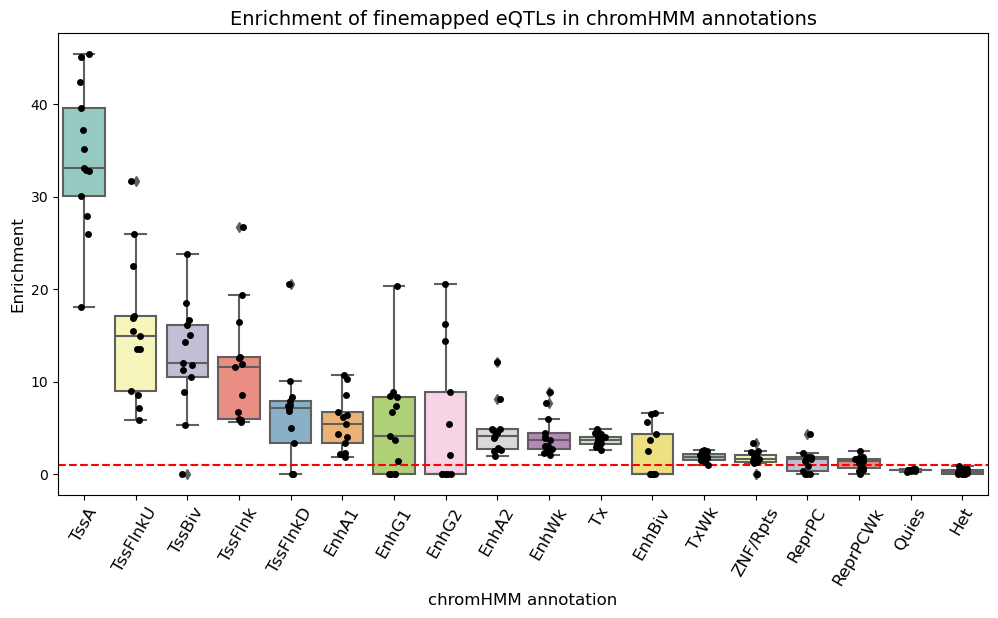

In [68]:
plot_enrichment()